In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score


### Web Scrape

In [2]:
url = 'https://www.honestdocs.co/hospitals/ramathibodi-hospital'
data = requests.get(url)
print(data.status_code) #2: success 4,5: error

comment = []
score = []
for i in range(1,100):
    r = requests.get(url, params=dict(query='web scraping',page=i))
    soup = BeautifulSoup(r.text,'html.parser')
    n = len(soup.find_all('div',{'class':'comments__content'}))
    for i in range(0,n):
        comment.append(soup.find_all('div',{'class':'comments__content'})[i].get_text().lstrip().strip())
        score.append(soup.find_all('span',{'class':'stars star-rating'})[i].attrs['data-score'])
        i +=1
    i +=1
    if len(soup.find_all('div',{'class':'comments__content'})) <= 0:
        break

200


### Translate

I save the translated file into CSV file as I was blocked for translate too many times in a day. Therefore, I comment the codes to prevent future translation.

In [3]:
#comment_eng = []
#translator = Translator()
#for i in range(0,len(comment)):
#    comment_eng.append(translator.translate(comment[i]).text)
#    i +=1
#
#print('comment: '+ str(len(comment)))
#print('comment_eng: '+ str(len(comment_eng)))
#print('score: '+ str(len(score)))

### Preprocessing

In [4]:
full_eng = pd.read_csv('comment_eng_score.csv')
full_eng2 = full_eng.drop_duplicates()
full_eng = full_eng.drop_duplicates()
full_eng2 = full_eng2.reset_index(drop=True)

#### Convert into full term

In [5]:
appos = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [6]:
full = full_eng2.iloc[:,0]
sen = []
for i in full:
    full2 = []
    full2.append(i.split())
    full_sen = []
    for j in range(len(full2)):
        for k in range(len(full2[j])):
            if full2[j][k] in appos:
                full_sen.append(appos[full2[j][k]])
            else:
                full_sen.append(full2[j][k])       
    sen.append(full_sen)

sen2 = []
for i in range(len(sen)):    
    sen2.append(" ".join(sen[i]))

full_eng2 = pd.DataFrame(sen2)
#full_eng3[1] = pd.to_numeric(full_eng3[1])

full_eng2.describe()
full_eng2.iloc[1,0]

"Maintained for many years since the age of 14 Will now have a bachelor's degree From sleeping in the midst of the arthropod until he recovered, he could live a normal life. In particular, premium clinics do not have to wait for a long time. There are convenient, fast, every step from paying to dispensing. The treatment fee is not too expensive when compared to many private services that are very good. Want everyone to come here"

### Discretize Comment
Those comments that are starred <= 3 is categorized as 0 (Negative Comment) and >= as 1 (Positive Comment)

In [7]:
full_eng2["sentiment"] = np.where(full_eng["1"] <= 3, 0,"")
full_eng2["sentiment"] = np.where(full_eng["1"] >= 4, 1,full_eng2["sentiment"])
full_eng2["sentiment"] = full_eng2["sentiment"].astype('float64')
full_eng2["sentiment"].value_counts()

full_eng22 = full_eng2.iloc[:,0].values
full_eng22_list = full_eng22.tolist()
df_full_eng22 = pd.DataFrame(full_eng22)

In [8]:
print(full_eng2["sentiment"].value_counts())

1.0    161
0.0     60
Name: sentiment, dtype: int64


There are total of 221 comments which more than 70% of comments are positive.

### List of stopwords

In [9]:
stopWords2 = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "'re"]

### Tokenize

In [10]:
word = []
for i in range(len(full_eng2)):
    blob = TextBlob(full_eng22[i])
    word.append(blob.lower().words) #convert into lower case

word2 = []
for i in range(len(word)):
    sentence = []
    for j in range(len(word[i])):
        if len(word[i][j]) > 2:
            sentence.append(word[i][j]) #collect only word that has more than 2 characters (remove acronyms, emoticons and conjunctions)
    word2.append(sentence)

### Remove stopwords

In [11]:
word3 = []
for i in range(len(word2)):
    x = []
    for j in range(len(word2[i])):
        if word2[i][j] not in stopWords2: 
            x.append(word2[i][j])
    word3.append(x)

### Lemmatization
I perform lemmatization with part-of-speech tagging to get better lemmatized words.

In [12]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

new_sen = []   
for i in range(len(word3)):
    l = []
    for k in range(len(word3[i])):
        l.append(word3[i][k].singularize())
        x2 = " ".join(l)
    new_sen.append(x2)

new_sen2 = []
[new_sen2.append(lemmatize_with_postag(new_sen[i])) for i in range(len(new_sen))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [13]:
new_sen2[0:4]

['use lasik good year since effect price also good cut may look scary really time not hurt drop anesthetic dissection',
 'maintain many year since age bachelor degree sleep midst arthropod recover could live normal life particular premium clinic not wait long time convenient fast every step pay dispense treatment fee not expensive compare many private service good want everyone come',
 '2nd floor phra thep build place look modern pressure measure room person temple think not nurse wear purple dres like scold person come temple speak stiffly person come measure pressure spite nurse put nurse gown say want improve come doctor surgery department tawut tell surgery say surgery heal time shock surgery fog go not really tell distance roi-laem meeting nurse nuek kyu not care repeat say correct say conclusion seem good wait see surgery',
 'public hospital service bad nurse completely unfriendly doctor god complex plu horrify bed side manner keep alive nothing quality life decent drug collectio

### Stemming
Convert plural into singular.

In [14]:
new_sen3 = []
for i in range(len(new_sen2)):
    text = TextBlob(new_sen2[i])
    a_sentence = []
    a = text.words
    for k in range(len(a)):
        a_sentence.append(a[k].singularize())
        x2 = " ".join(a_sentence)
    new_sen3.append(x2)

In [15]:
new_sen3[0:4]

['use lasik good year since effect price also good cut may look scary really time not hurt drop anesthetic dissection',
 'maintain many year since age bachelor degree sleep midst arthropod recover could live normal life particular premium clinic not wait long time convenient fast every step pay dispense treatment fee not expensive compare many private service good want everyone come',
 '2nd floor phra thep build place look modern pressure measure room person temple think not nurse wear purple dre like scold person come temple speak stiffly person come measure pressure spite nurse put nurse gown say want improve come doctor surgery department tawut tell surgery say surgery heal time shock surgery fog go not really tell distance roi-laem meeting nurse nuek kyu not care repeat say correct say conclusion seem good wait see surgery',
 'public hospital service bad nurse completely unfriendly doctor god complex plu horrify bed side manner keep alive nothing quality life decent drug collection

### Remove Numbers
Numbers are irrelevant in performing sentiment analysis for ramathibodi hospital.

In [16]:
import re
new_sen4 = []
for i in range(len(new_sen3)):
    new_sen4.append(re.sub(r'\d+', "", new_sen3[i]))

In [17]:
new_sen4[0:4]

['use lasik good year since effect price also good cut may look scary really time not hurt drop anesthetic dissection',
 'maintain many year since age bachelor degree sleep midst arthropod recover could live normal life particular premium clinic not wait long time convenient fast every step pay dispense treatment fee not expensive compare many private service good want everyone come',
 'nd floor phra thep build place look modern pressure measure room person temple think not nurse wear purple dre like scold person come temple speak stiffly person come measure pressure spite nurse put nurse gown say want improve come doctor surgery department tawut tell surgery say surgery heal time shock surgery fog go not really tell distance roi-laem meeting nurse nuek kyu not care repeat say correct say conclusion seem good wait see surgery',
 'public hospital service bad nurse completely unfriendly doctor god complex plu horrify bed side manner keep alive nothing quality life decent drug collection 

### Remove Acronyms, Emoticons and Conjunctions

Only retain the words that have more than 2 characters.

In [18]:
new_sen5 = []
for i in range(len(new_sen4)):
    word = []
    blob = TextBlob(new_sen4[i])
    word.append(blob.words)
    for i in range(len(word)):
        sentence = []
        for j in range(len(word[i])):
            if len(word[i][j]) > 2:
                sentence.append(word[i][j])
    new_sen5.append(sentence)

### Convert n't to not

In [19]:
new_sen6 = []
for i in range(len(new_sen5)):
    sen = []
    for j in range(len(new_sen5[i])):
        if new_sen5[i][j] == "n't":
            sen.append('not')
        else:
            sen.append(new_sen5[i][j])
    new_sen6.append(sen)

new_sen7 = []
for i in range(len(new_sen6)):
    sentence = []
    for k in new_sen6[i]:
        sentence.append(k)
        x2 = " ".join(sentence)
    new_sen7.append(x2)

List of all words

In [20]:
total_word = [new_sen6[i][j] for i in range(len(new_sen6)) for j in range(len(new_sen6[i]))]

In [21]:
df_all = full_eng2.copy()
df_new_sen7 = pd.DataFrame(new_sen7)
df_all['final_sen'] = df_new_sen7

In [22]:
df_all.head()

,0,sentiment,final_sen
0,"I used to go to LASIK here. Very good. Now, it...",1.0,use lasik good year since effect price also go...
1,Maintained for many years since the age of 14 ...,1.0,maintain many year since age bachelor degree s...
2,"At the 2nd floor of Phra Thep building, the pl...",0.0,floor phra thep build place look modern pressu...
3,Its a public hospital so service is bad (nurse...,1.0,public hospital service bad nurse completely u...
4,"My friend is a lung disease, a leaky lung, a d...",1.0,friend lung disease leaky lung doctor look tre...


In [23]:
print(total_word[0:300])
print("Number of words: ", len(total_word))
print("Number of unique words: ",len(set(total_word)))

['use', 'lasik', 'good', 'year', 'since', 'effect', 'price', 'also', 'good', 'cut', 'may', 'look', 'scary', 'really', 'time', 'not', 'hurt', 'drop', 'anesthetic', 'dissection', 'maintain', 'many', 'year', 'since', 'age', 'bachelor', 'degree', 'sleep', 'midst', 'arthropod', 'recover', 'could', 'live', 'normal', 'life', 'particular', 'premium', 'clinic', 'not', 'wait', 'long', 'time', 'convenient', 'fast', 'every', 'step', 'pay', 'dispense', 'treatment', 'fee', 'not', 'expensive', 'compare', 'many', 'private', 'service', 'good', 'want', 'everyone', 'come', 'floor', 'phra', 'thep', 'build', 'place', 'look', 'modern', 'pressure', 'measure', 'room', 'person', 'temple', 'think', 'not', 'nurse', 'wear', 'purple', 'dre', 'like', 'scold', 'person', 'come', 'temple', 'speak', 'stiffly', 'person', 'come', 'measure', 'pressure', 'spite', 'nurse', 'put', 'nurse', 'gown', 'say', 'want', 'improve', 'come', 'doctor', 'surgery', 'department', 'tawut', 'tell', 'surgery', 'say', 'surgery', 'heal', 'time'

### Train/Test
There are less than 30% that are negative comments which could lead to underperform for predicting negative comment. Therefore, I use 80% of data for train and 20% as test set.
I didn't try to balance class as it would bias the customers comment.

In [24]:
def train_test (df_all):
    from sklearn.model_selection import train_test_split
    mat_all = df_all.values
    X = mat_all[:,2]
    y = mat_all[:,1]
    
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
    
    y_train = np.float64(y_train)
    y_test = np.float64(y_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test(df_all)

### TFIDF

In [25]:
cv = TfidfVectorizer()

X_train_word_features = cv.fit_transform(X_train)
X_test_word_features = cv.transform(X_test)

#### Visualize common words

In [26]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

View most common words in train set

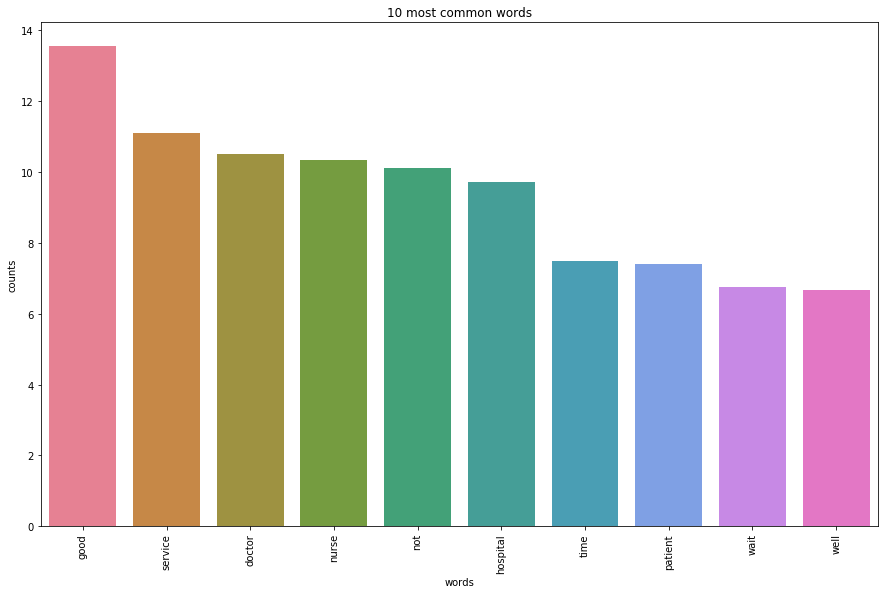

In [27]:
train_10_most_common = plot_10_most_common_words(X_train_word_features, cv)

View most common words in test set

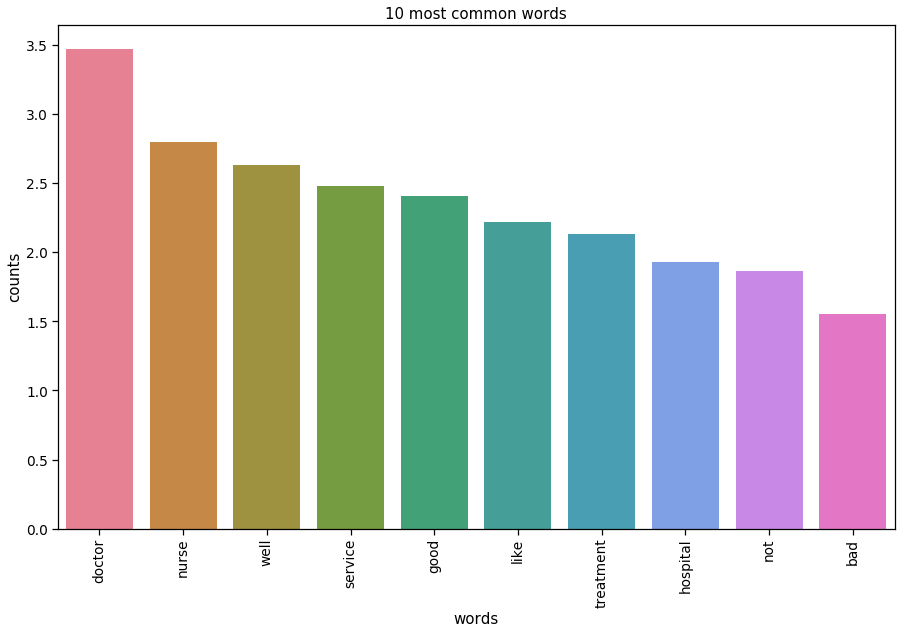

In [28]:
test_10_most_common = plot_10_most_common_words(X_test_word_features, cv)

### LDA

In [29]:
lda = LatentDirichletAllocation(random_state = 28)

### Modelling

The evaluation score used in this case is balanced accuracy score as the data has very high imbalanced class. The train dataset will be use to train the model. Cross validation will be use to tune the model paramters and test datase will be use for model evaluation.

#### SVM

In [31]:
def svm (X_train, X_test, y_train, y_test):
    lda = LatentDirichletAllocation(random_state = 28)
    svm = SVC(kernel='linear',verbose=1, probability=True)
    
    pipe = Pipeline([
            ('cv', cv),
            ('lda', lda),
            ('svm', svm)
            ])
    
    params = {'svm__C': np.arange(1,20),
              'lda__n_components': np.arange(1,100),
              'svm__kernel': ['linear','rbf','poly','sigmoid'],
              'cv__ngram_range': [(1,1),(1,2),(1,3),(1,4),(1,5)]}
    
    rs_svm = RandomizedSearchCV(estimator=pipe,
                             param_distributions=params,
                             cv=10,
                             n_jobs=-1,
                             random_state=42,
                             scoring='balanced_accuracy',
                             iid=True)
    
    rs_svm.fit(X_train,y_train)
    rs_svm.best_params_
    rs_svm.best_score_
    rs_svm.best_estimator_.predict(X_train)
    
    param_grids = {'svm__C': np.arange(rs_svm.best_params_["svm__C"]*0.8, rs_svm.best_params_["svm__C"]*1.2),
                   'svm__kernel': ['linear','rbf','poly','sigmoid'],
                   'lda__n_components': np.arange(rs_svm.best_params_["lda__n_components"]-10,rs_svm.best_params_["lda__n_components"]+10,1),
                   'cv__ngram_range': [(1,rs_svm.best_params_['cv__ngram_range'][1]+1),
                                       (1,rs_svm.best_params_['cv__ngram_range'][1]+2)]
                  } 
    
    gs_svm = GridSearchCV(estimator=pipe, 
                          param_grid=param_grids, 
                          scoring='balanced_accuracy',
                          n_jobs=-1,
                          iid=True)   
    
    gs_svm.fit(X_train, y_train)
    gs_svm.best_params_
    gs_svm.best_score_
    
    svm_scores = cross_val_score(gs_svm.best_estimator_, X_train, y_train, cv=10)
    svm_scores.mean()
    
    yhat_svm = gs_svm.best_estimator_.predict(X_test)
    prob_svm = gs_svm.best_estimator_.predict_proba(X_test)[:,1]
    
    #Evalutation
    svm = {}
    svm["acc"] = round(balanced_accuracy_score(y_test, yhat_svm), 2)
    svm["prob"] = prob_svm
    svm["con_mat"] = confusion_matrix(y_test, yhat_svm, labels=[1,0])
    svm["precision", "recall", "thresholds"] = precision_recall_curve(y_test, prob_svm, pos_label=1)
    svm["ROC"] = round(roc_auc_score(y_test, prob_svm), 2)
    svm["AP"] = round(average_precision_score(y_test, gs_svm.best_estimator_.predict_proba(X_test)[:,1]), 2)
        #Cross validation from train
    svm["CV"] = round(svm_scores.mean(), 2)
    svm["final_params"] = gs_svm.best_params_
    svm["yhat_nb"] = gs_svm.best_estimator_.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, prob_svm, pos_label=1)
    svm["fpr"] = fpr
    svm["tpr"] = tpr
    svm["thresholds"] = thresholds
        
        #Plot Confusion Matrix
    plt.clf()
    figcm_svm = plt.figure()
    plt.imshow(svm["con_mat"], interpolation='nearest', cmap=plt.cm.Wistia)
    plt.colorbar()
    classNames = ['Positive','Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]   
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(svm["con_mat"][i][j]))
        #ROC Curve
    figROC_svm, ax = plt.subplots(figsize=(6, 6))
    ax.plot(svm["fpr"], svm["tpr"], color="tomato", label="SVM, auc=" + str(svm["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    
        #Plotting PR Curve
    figPR_svm, ax = plt.subplots(figsize=(6, 6))
    ax.plot(svm["precision","recall","thresholds"][1], svm["precision","recall","thresholds"][0], color="green", label="SVM, average precision=" + str(svm["AP"]))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")
    
    return svm, figcm_svm, figROC_svm, figPR_svm


[LibSVM]

D:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

<Figure size 432x288 with 0 Axes>

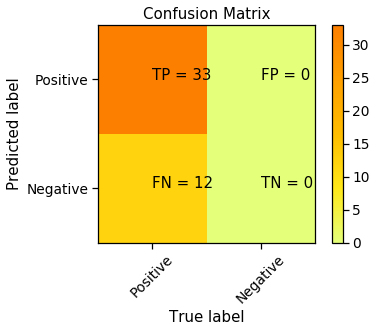

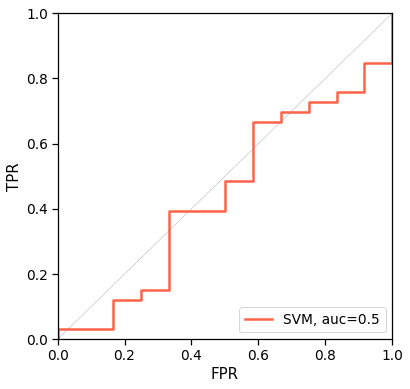

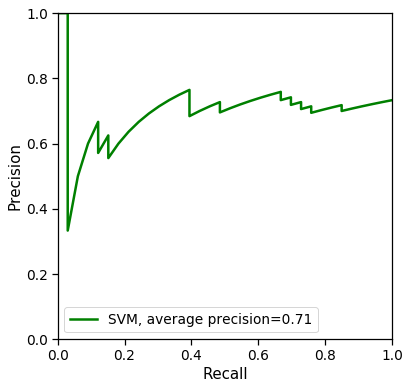

In [32]:
svm, figcm_svm, figROC_svm, figPR_svm = svm(X_train, X_test, y_train, y_test)

### Naive Bayes

In [33]:
def nbay (X_train, X_test, y_train, y_test):
    from sklearn.naive_bayes import ComplementNB
    nb = ComplementNB()
    
    pipe2 = Pipeline([
            ('cv', cv),
            ('lda', lda),
            ('nb', nb)
            ])
     
    params2 = {'lda__n_components': np.arange(1,100),
               'cv__ngram_range': [(1,1),(1,2),(1,3),(1,4),(1,5)]}
    
    rs_nb = RandomizedSearchCV(estimator=pipe2,
                             param_distributions=params2,
                             cv=10,
                             n_jobs=-1,
                             random_state=42,
                             scoring='balanced_accuracy',
                             iid=True)
    
    rs_nb.fit(X_train,y_train)
    rs_nb.best_params_
    rs_nb.best_score_
    rs_nb.best_estimator_.predict(X_train)
    
    param_grids2 = {'lda__n_components': np.arange(rs_nb.best_params_["lda__n_components"]-10,
                                                   rs_nb.best_params_["lda__n_components"]+10,1),
                    'cv__ngram_range': [(1,rs_nb.best_params_['cv__ngram_range'][1]+1),
                                       (1,rs_nb.best_params_['cv__ngram_range'][1]+2)]
                    } 
    
    gs_nb = GridSearchCV(estimator=pipe2, 
                          param_grid=param_grids2, 
                          scoring='balanced_accuracy',
                          n_jobs=-1,
                          iid=True)   
    
    gs_nb.fit(X_train, y_train)
    gs_nb.best_params_
    gs_nb.best_score_
    
    nb_scores = cross_val_score(gs_nb.best_estimator_, X_train, y_train, cv=10)
    nb_scores.mean()
    
    yhat_nb = gs_nb.best_estimator_.predict(X_test)
    prob_nb = gs_nb.best_estimator_.predict_proba(X_test)[:,1]

    nb = {}
    nb["acc"] = round(balanced_accuracy_score(y_test, yhat_nb), 2)
    nb["con_mat"] = confusion_matrix(y_test, yhat_nb, labels=[1,0])
    nb["ROC"] = round(roc_auc_score(y_test, prob_nb), 2)
    nb["AP"] = round(average_precision_score(y_test, prob_nb), 2)
    nb["CV"] = nb_scores.mean()
    nb["final_params"] = gs_nb.best_params_
    nb["yhat_nb"] = gs_nb.best_estimator_.predict(X_test)
    nb["prob"] = prob_nb
    nb["precision", "recall", "thresholds"] = precision_recall_curve(y_test, prob_nb, pos_label=1)
    
    fpr, tpr, thresholds = roc_curve(y_test, nb["prob"], pos_label=1)
    nb["fpr"] = fpr
    nb["tpr"] = tpr
    nb["thresholds"] = thresholds
    
        #Ploting confusion matrix
    plt.clf()
    figcm_nb = plt.figure()
    plt.imshow(nb["con_mat"], interpolation='nearest', cmap=plt.cm.Wistia)
    plt.colorbar()
    classNames = ['Positive','Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]   
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(nb["con_mat"][i][j]))
    plt.show() 
    
        #Plotting ROC
    figROC_nb, ax = plt.subplots(figsize=(6, 6))
    ax.plot(nb["fpr"], nb["tpr"], color="tomato", label="Naive Bayes, auc=" + str(nb["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/NB1_ROC.png')
    plt.show()  
    
        #Plotting PR Curve
    figPR_nb, ax = plt.subplots(figsize=(6, 6))
    ax.plot(nb["precision","recall","thresholds"][1], nb["precision","recall","thresholds"][0], color="green", label="Naive Bayes, average precision=" + str(nb["AP"]))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/NB1_PR.png')
    plt.show()
    return nb, figcm_nb, figROC_nb, figPR_nb

D:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


<Figure size 432x288 with 0 Axes>

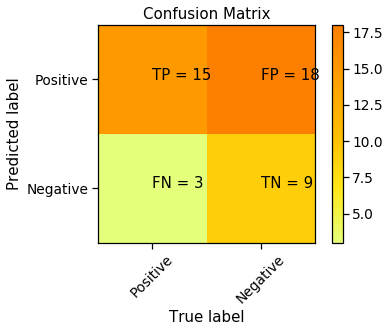

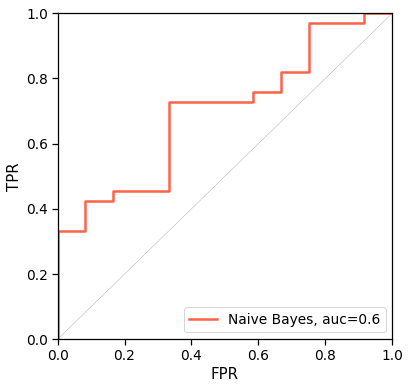

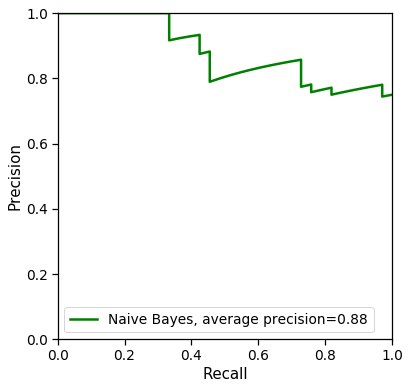

In [34]:
nb, figcm_nb, figROC_nb, figPR_nb = nbay(X_train, X_test, y_train, y_test)

### Decision Tree

In [35]:
def dt (X_train, X_test, y_train, y_test):
    from sklearn.tree import DecisionTreeClassifier
    dt = DecisionTreeClassifier(random_state=28)
    
    pipe3 = Pipeline([
            ('cv', cv),
            ('lda', lda),
            ('dt', dt)
            ])
    
    params3 = {
            'cv__ngram_range': [(1,1),(1,2),(1,3),(1,4),(1,5)],
            'lda__n_components': np.arange(1,100),
            "dt__criterion": ("gini", "entropy"),
            "dt__max_depth": np.arange(2, 10),
            "dt__min_samples_split": np.arange(2,10,1)
              }
    
    rs_dt = RandomizedSearchCV(estimator = pipe3, 
                               param_distributions = params3,
                               n_iter = 5, 
                               random_state=42,
                               scoring='balanced_accuracy', 
                               cv=10,
                               iid=True,
                               n_jobs=-1)
    
    rs_dt.fit(X_train, y_train)
    rs_dt.best_params_
    rs_dt.best_score_
    rs_dt.best_estimator_.predict(X_train)
    
    param_grids3 = {'lda__n_components': np.arange(rs_dt.best_params_["lda__n_components"]-5,rs_dt.best_params_["lda__n_components"]+5,1),
                    'cv__ngram_range': [(1,rs_dt.best_params_['cv__ngram_range'][1]+1),
                                       (1,rs_dt.best_params_['cv__ngram_range'][1]+2)],
                    "dt__criterion": ("gini", "entropy"),
                    "dt__max_depth": np.arange(rs_dt.best_params_["dt__max_depth"]-2, rs_dt.best_params_["dt__max_depth"]+2,1),
                    "dt__min_samples_split": np.arange(rs_dt.best_params_["dt__max_depth"]-2,rs_dt.best_params_["dt__max_depth"]+2,1)
                    } 
    
    gs_dt = GridSearchCV(estimator=pipe3, 
                         param_grid=param_grids3,
                         scoring='balanced_accuracy',
                         n_jobs=-1,
                         iid=True)   
    
    gs_dt.fit(X_train, y_train)
    gs_dt.best_params_
    gs_dt.best_score_
    
    dt_scores = cross_val_score(gs_dt.best_estimator_, X_train, y_train, cv=10)
    dt_scores.mean()
    
    yhat_dt = gs_dt.best_estimator_.predict(X_test)
    prob_dt = gs_dt.best_estimator_.predict_proba(X_test)[:,1]
    
    dt = {}
    dt["acc"] = round(balanced_accuracy_score(y_test, yhat_dt), 2)
    dt["prob"] = prob_dt
    dt["con_mat"] = confusion_matrix(y_test, yhat_dt, labels=[1,0])
    dt["precision", "recall", "thresholds"] = precision_recall_curve(y_test, prob_dt, pos_label=1)
    dt["ROC"] = round(roc_auc_score(y_test, prob_dt), 2)
    dt["AP"] = round(average_precision_score(y_test, prob_dt), 2)
    dt["CV"] = round(dt_scores.mean(), 2)
    dt["final_params"] = gs_dt.best_params_
    
    fpr, tpr, thresholds = roc_curve(y_test, dt["prob"], pos_label=1)
    dt["fpr"] = fpr
    dt["tpr"] = tpr
    dt["thresholds"] = thresholds
    
        #Ploting confusion matrix
    plt.clf()
    figcm_dt = plt.figure()
    plt.imshow(dt["con_mat"], interpolation='nearest', cmap=plt.cm.Wistia)
    plt.colorbar()
    classNames = ['Positive','Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]   
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(dt["con_mat"][i][j]))
    plt.show()

    #Plotting ROC    
    figROC_dt, ax = plt.subplots(figsize=(6, 6))
    ax.plot(dt["fpr"], dt["tpr"], color="tomato", label="Decision Tree, auc=" + str(dt["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/DT1_ROC.png')   
    plt.show()
    
    #Plotting PR Curve
    figPR_dt, ax = plt.subplots(figsize=(6, 6))
    ax.plot(dt["precision","recall","thresholds"][1], dt["precision","recall","thresholds"][0], color="green", label="Decision Tree, average precision=" + str(dt["AP"]))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")
#    plt.savefig('E:/MEGA 2 - Personal/Personal - Gmail/PhD/RADS602 Data Mining and Machine Learning/Assignment II Data/DT1_PR.png')
    plt.show()
    
    return dt, figcm_dt, figROC_dt, figPR_dt

D:\Users\User\Anaconda3\envs\CEB\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


<Figure size 432x288 with 0 Axes>

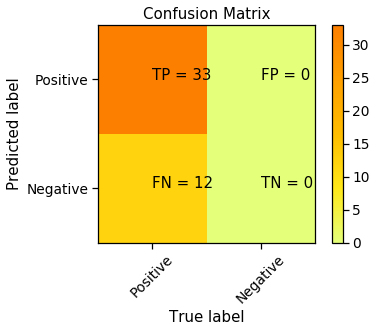

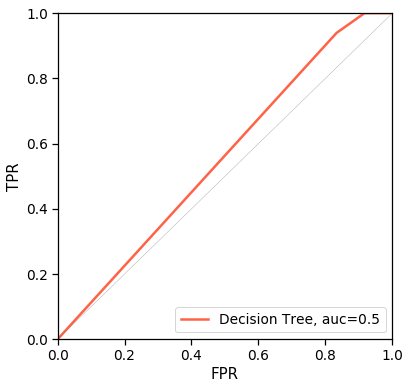

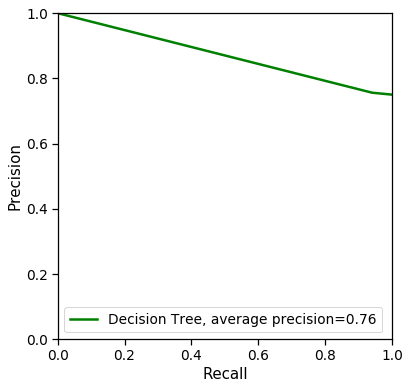

In [36]:
dt, figcm_dt, figROC_dt, figPR_dt = dt(X_train, X_test, y_train, y_test)

**Compare ROC and PR curve among all models**

In [37]:
def compare_ROC_PR (nb, dt, svm):
    figROC, ax = plt.subplots(figsize=(6, 6))
    ax.plot(nb["fpr"], nb["tpr"], label="Naive Bayes, auc=" + str(nb["ROC"]))
    ax.plot(dt["fpr"], dt["tpr"], label="Decision Tree, auc=" + str(dt["ROC"]))
    ax.plot(svm["fpr"], svm["tpr"], label="SVM, auc=" + str(svm["ROC"]))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    
    figPR, ax = plt.subplots(figsize=(6, 6))
    ax.plot(nb["precision","recall","thresholds"][1], 
            nb["precision","recall","thresholds"][0], 
            label="Naive Bayes, average precision=" + str(nb["AP"]))
    
    ax.plot(dt["precision","recall","thresholds"][1], 
            dt["precision","recall","thresholds"][0], 
            label="Decision Tree, average precision=" + str(dt["AP"]))
    ax.plot(svm["precision","recall","thresholds"][1], 
            svm["precision","recall","thresholds"][0], 
            label="SVM, average precision=" + str(svm["AP"]))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")   
    plt.show()
    
    return figROC, figPR

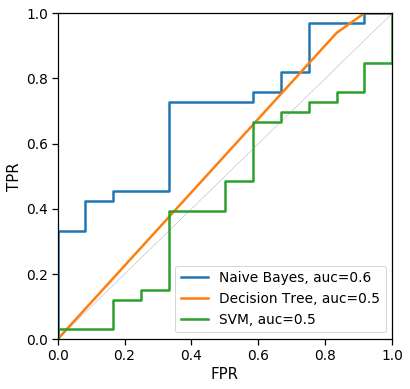

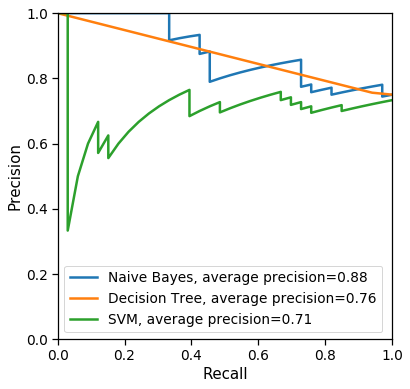

In [38]:
figROC, figPR = compare_ROC_PR(nb, dt, svm)

According to the result of SVM, Naive Bayes and Decision Tree, the best model to predict the Ramathibodi comment is Naive Bayes. Because NB has the best balanced_accuracy_score of 0.6, while other model is 0.5.
Also, the precision of the Naive Bayes is 0.88, highest among all the model. However, the results from these model didn't perform well as the balanced accuracy score is not good. This might be due very low number of negative comment which made the model difficult to distinguish the comments.

### Word Cloud

After predicted the comment in test set, the word cloud is used to determine which important words using TFIDF.

**In original data <br>**
Here, we just want to see the words in test data.

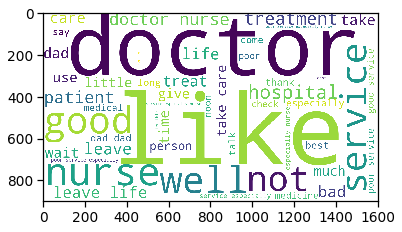

In [39]:
cv2 = TfidfVectorizer(ngram_range = (nb['final_params']['cv__ngram_range']))
X_test_word_features2 = cv2.fit_transform(X_test)
#Transform test data
sum_words = X_test_word_features2.sum(axis=0)

#Display word frequency with tfidf value
word_freq = [(word, sum_words[0, idx]) for word, idx in cv2.fit(X_test).vocabulary_.items()]

from wordcloud import WordCloud
w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=50).fit_words(dict(word_freq))
plt.imshow(w)
plt.show()

**Negative Comment <br>**
Now we perform word cloud using TFIDF for negative comments

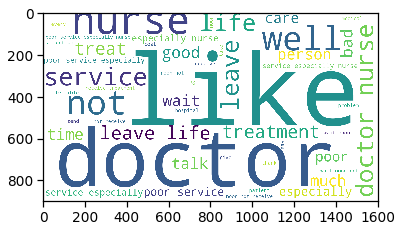

In [40]:
df_test = pd.DataFrame(X_test)
df_test["Predicted"] = nb["yhat_nb"]

df_test_0 = df_test[df_test["Predicted"] == 0]
df_test_1 = df_test[df_test["Predicted"] == 1]

X_test_0 = cv2.fit_transform(df_test_0[0])
X_test_0_sum = X_test_0.sum(axis=0)

word_freq = [(word, X_test_0_sum[0, idx]) for word, idx in cv2.fit(df_test_0[0]).vocabulary_.items()]

w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=50).fit_words(dict(word_freq))
plt.imshow(w)
plt.show()

**Negative Comment (Noun pharse) <br>**
Also, i want to perform TFIDF and word cloud only those noun phrase because noun usually better indicate negative side of Ramathibodi

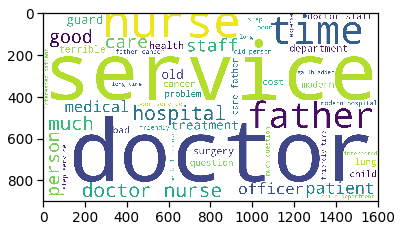

In [41]:
from textblob.np_extractors import ConllExtractor
extractor = ConllExtractor()

df_test_0_np = []
for i in df_test_0[0]:
    blob = TextBlob(i, np_extractor=extractor)
    df_test_0_np.append(blob.noun_phrases)

df_test_0_np1 = []
for i in range(len(df_test_0_np)):
    for j in range(len(df_test_0_np[i])):
        df_test_0_np1.append(df_test_0_np[i][j])

df_test_0_np1_tfidf = cv2.fit_transform(df_test_0_np1)
test_0_sum_words = df_test_0_np1_tfidf.sum(axis=0)
test_0_word_freq = [(word, test_0_sum_words[0, idx]) for word, idx in cv2.fit(df_test_0_np1).vocabulary_.items()]

w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=50).fit_words(dict(test_0_word_freq))
plt.imshow(w)
plt.show()

The result shows that there are duplicate words due to using n-gram during TFIDF. Also, there are some positive word, good, in negative comment which is not suppose to be in here. Some of the negative word that capture in here are "time, old, guard, question, staff, cancer, health problem, guard, poor service". This could be a hint that there might be some negative side of ramathibodi about timeliness and staff. Therefore, this could be use to improve about the timeliness of the service and improve behavior of the staff.

**Positive comments word cloud**

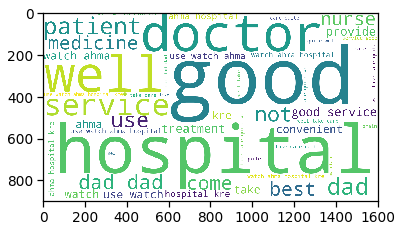

In [42]:
X_test_1 = cv2.fit_transform(df_test_1[0])
X_test_1_sum = X_test_1.sum(axis=0)

word_freq = [(word, X_test_1_sum[0, idx]) for word, idx in cv2.fit(df_test_1[0]).vocabulary_.items()]

w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=50).fit_words(dict(word_freq))
plt.imshow(w)
plt.show()

**Positive comment word cloud (Noun pharse)**

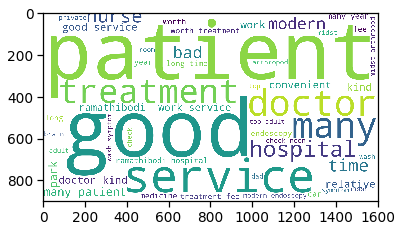

In [43]:
df_test_1_np = []
for i in df_test_1[0]:
    blob = TextBlob(i, np_extractor=extractor)
    df_test_1_np.append(blob.noun_phrases)

df_test_1_np1 = []
for i in range(len(df_test_1_np)):
    for j in range(len(df_test_1_np[i])):
        df_test_1_np1.append(df_test_1_np[i][j])

df_test_1_np1_tfidf = cv2.fit_transform(df_test_1_np1)
test_1_sum_words = df_test_1_np1_tfidf.sum(axis=0)
test_1_word_freq = [(word, test_1_sum_words[0, idx]) for word, idx in cv2.fit(df_test_1_np1).vocabulary_.items()]

w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=50).fit_words(dict(test_1_word_freq))
plt.imshow(w)
plt.show()

The result is similar to the previous negative word cloud. There is some words that should not be in here, such as "bad". The are multiple duplication of words due to using opitmal n-gram from naive bayes result. Some of the key word here for positive side are "doctor, treatment, service, park, conveninet and etc".

**Word cloud using Term Frequency rather than TFIDF** <br>
Rather than using TFIDF, I will try to use term frequency to indicate important word as there are not many words in this case.

**Negative Comment (Noun Phase)**

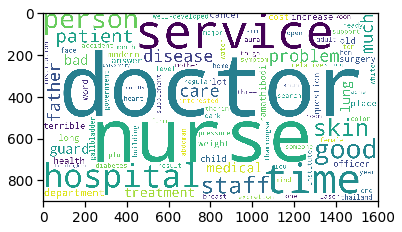

In [44]:
df = pd.DataFrame(df_test_0_np1)
df = df[0].str.split()

df_tf_test_0_np = []
for i in range(len(df)):
    for j in range(len(df[i])):
        df_tf_test_0_np.append(df[i][j])
    
tf_test_0_np = Counter(df_tf_test_0_np)

w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=50).fit_words(tf_test_0_np)
plt.imshow(w)
plt.show()

**Positive Comment (Noun Phase)**

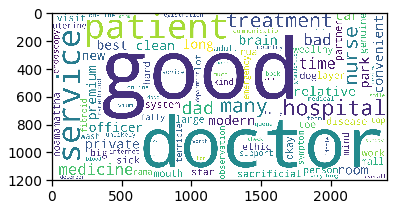

In [45]:
df2 = pd.DataFrame(df_test_1_np1)
df2 = df2[0].str.split()

df_tf_test_1_np = []
for i in range(len(df2)):
    for j in range(len(df2[i])):
        df_tf_test_1_np.append(df2[i][j])
    
tf_test_1_np = Counter(df_tf_test_1_np)

w = WordCloud(width=2400,height=1200,mode='RGBA',background_color='white',max_words=50).fit_words(tf_test_1_np)
plt.imshow(w)
plt.show()

Changing from TFIDF to term frequncy didn't change the result that much as the words is not large. Also, some of the words that shouldn't be in the negative comment, for example 'good', are shown. This might be due to the model inaccurately predict the negative comment into positive comment. Lastly, there is large room for improvement in this model to predict the positive and negative comment as the model has the accuracy of 60%. This could be improve by having more negative comment samples or using deep learning method in order to distinguish features that normal model cannot be done.<br><br>
For suggestion to Ramathibodi management, according to the model, we should improve services especially in term of timeliness of the service. Also, we should train personnel to give better experience while admit in the hospital. Moreover, some of the comment suggest that we can improve in hospital hygiene and increase in number of car park. <br>